# Setup

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
from scipy.stats import norm
import statistics
import pickle

# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

participants_num = len(HCPS.keys())
HCPS.keys()

dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6', 'subject7', 'subject8', 'subject9', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14'])

In [2]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real

M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions

#scaling factors for output screen and input slider
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

C:\Users\hachou\AppData\Local\Temp/ipykernel_17224/1718450180.py:8: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
C:\Users\hachou\AppData\Local\Temp/ipykernel_17224/1718450180.py:8: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


In [3]:
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# Simulations of one


## simulated y for 1 trial

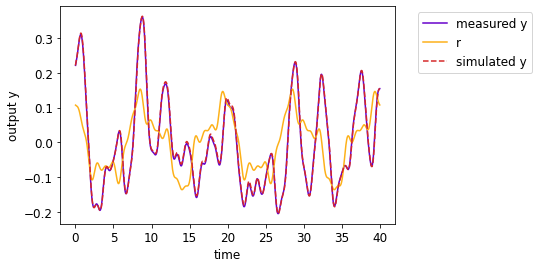

In [4]:
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

i = 9 #trial number

x0 = np.asarray(HCPS['subject0']['condition0']['trial'+str(i)]['state_'][0])

# make "input" u+d
u_d = lambda t: (DATA['TIME']['subject0']['condition0']['u'][i][int(t/dt)] + DATA['TIME']['subject0']['condition0']['d'][i][int(t/dt)])/scaleInput

def so(t,x,u):
  """
  second-order machine M
  # A = np.array([[0,1],[0,-b]])
  # B = np.array([[0],[1]])
  # C = np.array([1,0])
  """
  b = 1.0
  q,dq = x
  ddq = u
  return np.hstack((dq,ddq - b*dq))
  
t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d)

plt.plot(t-5,DATA['TIME']['subject0']['condition0']['y'][i],label='measured y',color= colors['y'])
plt.plot(t-5,DATA['TIME']['subject0']['condition0']['r'][i],label='r',color= colors['r'])

plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated y',color= colors['RED'])
# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [5]:
t

array([ 5.01666667,  5.03333333,  5.05      , ..., 44.96666667,
       44.98333333, 45.        ])

In [6]:
t_

array([0.00000000e+00, 1.66666667e-02, 3.33333333e-02, ...,
       3.99666667e+01, 3.99833333e+01, 4.00000000e+01])

## simulated y0,y1 for 1 trial from u0, u1

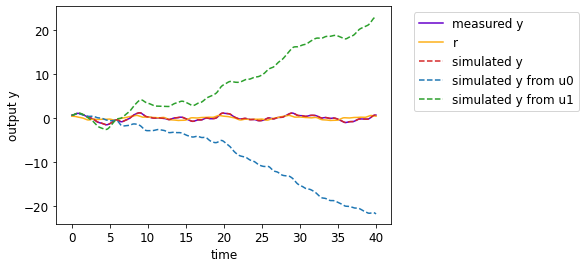

In [7]:
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

def so(t,x,u):
    """
    second-order machine M
    # A = np.array([[0,1],[0,-b]])
    # B = np.array([[0],[1]])
    # C = np.array([1,0])
    """
    b = 1.0
    q,dq = x
    ddq = u
    return np.hstack((dq,ddq - b*dq))

i = 9 #trial number

x0 = np.asarray(HCPS['subject0']['condition2']['trial'+str(i)]['state_'][0])

# make "input" u+d
u_d = lambda t: (DATA['TIME']['subject0']['condition2']['u'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d)

u0_d = lambda t: (DATA['TIME']['subject0']['condition2']['u0'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
t_0,x_0 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u0_d)

u1_d = lambda t: (DATA['TIME']['subject0']['condition2']['u1'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
t_1,x_1 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u1_d)

plt.plot(t-5,DATA['TIME']['subject0']['condition2']['y'][i]/scaleOutputScreen,label='measured y',color=colors['y'])
plt.plot(t-5,DATA['TIME']['subject0']['condition0']['r'][i]/scaleOutputScreen,label='r',color= colors['r'])
plt.plot(t_,x_[:,0],'--',label='simulated y',color=colors['RED'])
plt.plot(t_0,x_0[:,0],'--',label='simulated y from u0',color=colors['BLUE'])
plt.plot(t_1,x_1[:,0],'--',label='simulated y from u1',color=colors['GREEN'])
# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


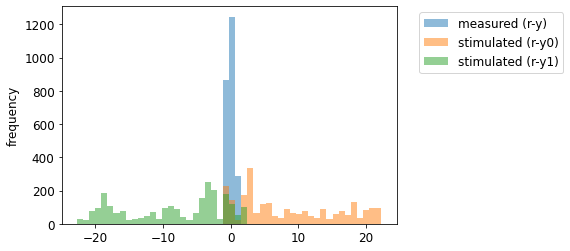

In [8]:
#overall time domain tracking error of a trial in a histogram
y__ = DATA['TIME']['subject0']['condition2']['y'][i]/scaleOutputScreen
r__ = DATA['TIME']['subject0']['condition0']['r'][i]/scaleOutputScreen

bins=np.histogram(np.hstack(((r__ - y__),(r__ - x_0[:,0][1:]),(r__ - x_1[:,0][1:]))), bins=50)[1] #get the bin edg
plt.hist((r__ - y__),bins,alpha=0.5,label = 'measured (r-y)')
plt.hist((r__ - x_0[:,0][1:]),bins,alpha=0.5,label = 'stimulated (r-y0)')
plt.hist((r__ - x_1[:,0][1:]),bins,alpha=0.5,label = 'stimulated (r-y1)')

plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 


# Simulations of all fusion conditions


In [9]:
# same for all trials and all conditions
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

def so(t,x,u):
    """
    second-order machine M
    # A = np.array([[0,1],[0,-b]])
    # B = np.array([[0],[1]])
    # C = np.array([1,0])
    """
    b = 1.0
    q,dq = x
    ddq = u
    return np.hstack((dq,ddq - b*dq))

In [10]:
SIM = {}
for p in range(participants_num):
    SIM['subject'+str(p)] = {}
    for c in [2,3,4]:
        SIM['subject'+str(p)]['condition'+str(c)] = {}
        SIM['subject'+str(p)]['condition'+str(c)]['y'] = []
        SIM['subject'+str(p)]['condition'+str(c)]['y0'] = []
        SIM['subject'+str(p)]['condition'+str(c)]['y1'] = []
        SIM['subject'+str(p)]['condition'+str(c)]['Y'] = []
        SIM['subject'+str(p)]['condition'+str(c)]['Y0'] = []
        SIM['subject'+str(p)]['condition'+str(c)]['Y1'] = []
        for i in range(trialnum[c]):
            #initial cond
            x0 = np.asarray(HCPS['subject'+str(p)]['condition'+str(c)]['trial'+str(i)]['state_'][0])

            u_d = lambda t: (DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i][int(t/dt)] + DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
            t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d) # make "input" = u+d
            x_ = x_[:,0][:-1] #len = 2400, remove the last x
            X_ = FFT(x_,N) #freq domain

            u0_d = lambda t: (DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i][int(t/dt)] + DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
            t_0,x_0 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u0_d)
            x_0 = x_0[:,0][:-1]
            X_0 = FFT(x_0,N)

            u1_d = lambda t: (DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i][int(t/dt)] + DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
            t_1,x_1 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u1_d)
            x_1 = x_1[:,0][:-1]
            X_1 = FFT(x_1,N)

            #time-domain
            SIM['subject'+str(p)]['condition'+str(c)]['y'].append(x_*scaleOutputScreen) #simulated y for one trial
            SIM['subject'+str(p)]['condition'+str(c)]['y0'].append(x_0*scaleOutputScreen) #simulated y0 for one trial
            SIM['subject'+str(p)]['condition'+str(c)]['y1'].append(x_1*scaleOutputScreen) #simulated y1 for one trial

            #freq-domain
            SIM['subject'+str(p)]['condition'+str(c)]['Y'].append(X_*scaleOutputScreen) #simulated y for one trial
            SIM['subject'+str(p)]['condition'+str(c)]['Y0'].append(X_0*scaleOutputScreen) #simulated y0 for one trial
            SIM['subject'+str(p)]['condition'+str(c)]['Y1'].append(X_1*scaleOutputScreen) #simulated y1 for one trial


In [11]:
# DATA['TIME']['subject'+str(0)]['condition'+str(2)]['y'][0]

In [12]:
# SIM['subject'+str(0)]['condition'+str(2)]['y'][0]

In [13]:
# DATA['FREQ']['subject'+str(0)]['condition'+str(2)]['Y'][0]

In [14]:
# SIM['subject'+str(0)]['condition'+str(2)]['Y'][0]

In [15]:
import pickle
c_file = open("SIM.pkl", "wb")
pickle.dump(SIM, c_file)
c_file.close()

# others

## condition 2 (50%)

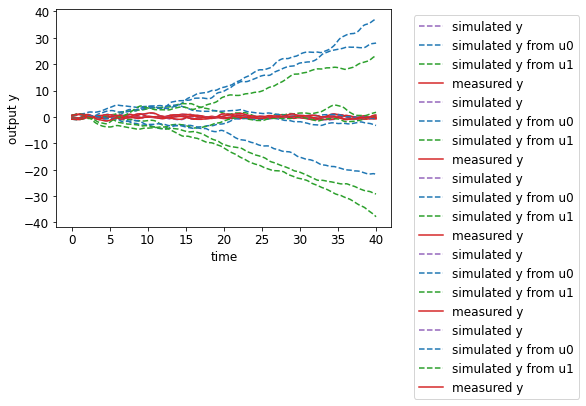

In [16]:
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

def so(t,x,u):
    """
    second-order machine M
    # A = np.array([[0,1],[0,-b]])
    # B = np.array([[0],[1]])
    # C = np.array([1,0])
    """
    b = 1.0
    q,dq = x
    ddq = u
    return np.hstack((dq,ddq - b*dq))

for i in [5,6,7,8,9]: #see what trials

    x0 = np.asarray(HCPS['subject0']['condition2']['trial'+str(i)]['state_'][0])

    # make "input" u+d
    u_d = lambda t: (DATA['TIME']['subject0']['condition2']['u'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
    t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d)

    u0_d = lambda t: (DATA['TIME']['subject0']['condition2']['u0'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
    t_0,x_0 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u0_d)

    u1_d = lambda t: (DATA['TIME']['subject0']['condition2']['u1'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
    t_1,x_1 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u1_d)

    plt.plot(t_,x_[:,0],'--',label='simulated y',color=colors['PURPLE'])
    plt.plot(t_0,x_0[:,0],'--',label='simulated y from u0',color=colors['BLUE'])
    plt.plot(t_1,x_1[:,0],'--',label='simulated y from u1',color=colors['GREEN'])

    plt.plot(t-5,DATA['TIME']['subject0']['condition2']['y'][i]/scaleOutputScreen,label='measured y',color=colors['RED'])

# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


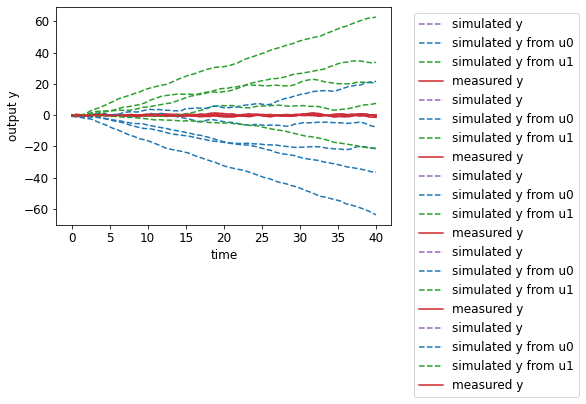

In [17]:
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

def so(t,x,u):
    """
    second-order machine M
    # A = np.array([[0,1],[0,-b]])
    # B = np.array([[0],[1]])
    # C = np.array([1,0])
    """
    b = 1.0
    q,dq = x
    ddq = u
    return np.hstack((dq,ddq - b*dq))

for i in [0,1,2,3,4]: #see what trials

    x0 = np.asarray(HCPS['subject0']['condition2']['trial'+str(i)]['state_'][0])

    # make "input" u+d
    u_d = lambda t: (DATA['TIME']['subject0']['condition2']['u'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
    t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d)

    u0_d = lambda t: (DATA['TIME']['subject0']['condition2']['u0'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
    t_0,x_0 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u0_d)

    u1_d = lambda t: (DATA['TIME']['subject0']['condition2']['u1'][i][int(t/dt)] + DATA['TIME']['subject0']['condition2']['d'][i][int(t/dt)])/scaleInput
    t_1,x_1 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u1_d)

    plt.plot(t_,x_[:,0],'--',label='simulated y',color=colors['PURPLE'])
    plt.plot(t_0,x_0[:,0],'--',label='simulated y from u0',color=colors['BLUE'])
    plt.plot(t_1,x_1[:,0],'--',label='simulated y from u1',color=colors['GREEN'])

    plt.plot(t-5,DATA['TIME']['subject0']['condition2']['y'][i]/scaleOutputScreen,label='measured y',color=colors['RED'])

# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


## condition 3 (25%EMG)

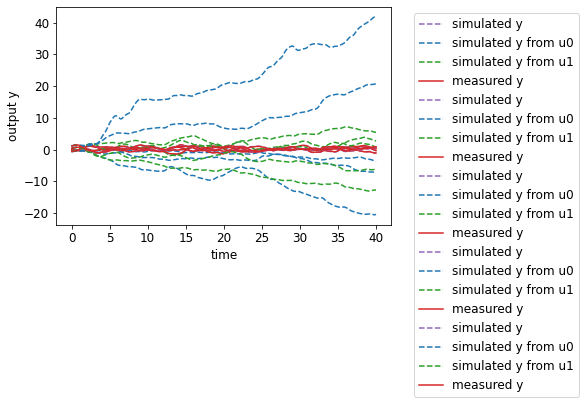

In [18]:
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

def so(t,x,u):
    """
    second-order machine M
    # A = np.array([[0,1],[0,-b]])
    # B = np.array([[0],[1]])
    # C = np.array([1,0])
    """
    b = 1.0
    q,dq = x
    ddq = u
    return np.hstack((dq,ddq - b*dq))

c = 3 #what condition

for i in [5,6,7,8,9]: #see what trials

    x0 = np.asarray(HCPS['subject0']['condition'+str(c)]['trial'+str(i)]['state_'][0])

    # make "input" u+d
    u_d = lambda t: (DATA['TIME']['subject0']['condition'+str(c)]['u'][i][int(t/dt)] + DATA['TIME']['subject0']['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
    t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d)

    u0_d = lambda t: (DATA['TIME']['subject0']['condition'+str(c)]['u0'][i][int(t/dt)] + DATA['TIME']['subject0']['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
    t_0,x_0 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u0_d)

    u1_d = lambda t: (DATA['TIME']['subject0']['condition'+str(c)]['u1'][i][int(t/dt)] + DATA['TIME']['subject0']['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
    t_1,x_1 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u1_d)

    plt.plot(t_,x_[:,0],'--',label='simulated y',color=colors['PURPLE'])
    plt.plot(t_0,x_0[:,0],'--',label='simulated y from u0',color=colors['BLUE'])
    plt.plot(t_1,x_1[:,0],'--',label='simulated y from u1',color=colors['GREEN'])

    plt.plot(t-5,DATA['TIME']['subject0']['condition'+str(c)]['y'][i]/scaleOutputScreen,label='measured y',color=colors['RED'])

# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


## condition 4 (75% EMG)

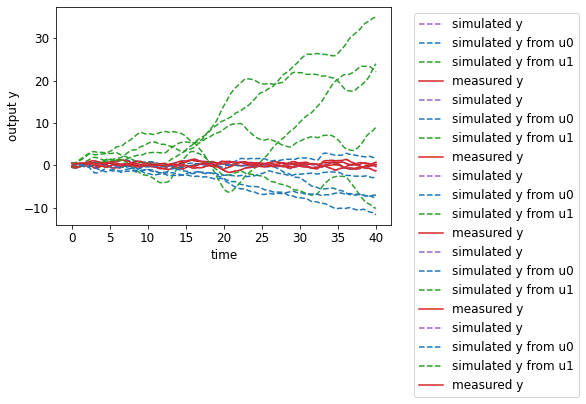

In [19]:
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

def so(t,x,u):
    """
    second-order machine M
    # A = np.array([[0,1],[0,-b]])
    # B = np.array([[0],[1]])
    # C = np.array([1,0])
    """
    b = 1.0
    q,dq = x
    ddq = u
    return np.hstack((dq,ddq - b*dq))

c = 4 #what condition

for i in [5,6,7,8,9]: #see what trials

    x0 = np.asarray(HCPS['subject0']['condition'+str(c)]['trial'+str(i)]['state_'][0])

    # make "input" u+d
    u_d = lambda t: (DATA['TIME']['subject0']['condition'+str(c)]['u'][i][int(t/dt)] + DATA['TIME']['subject0']['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
    t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d)

    u0_d = lambda t: (DATA['TIME']['subject0']['condition'+str(c)]['u0'][i][int(t/dt)] + DATA['TIME']['subject0']['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
    t_0,x_0 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u0_d)

    u1_d = lambda t: (DATA['TIME']['subject0']['condition'+str(c)]['u1'][i][int(t/dt)] + DATA['TIME']['subject0']['condition'+str(c)]['d'][i][int(t/dt)])/scaleInput
    t_1,x_1 = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u1_d)

    plt.plot(t_,x_[:,0],'--',label='simulated y',color=colors['PURPLE'])
    plt.plot(t_0,x_0[:,0],'--',label='simulated y from u0',color=colors['BLUE'])
    plt.plot(t_1,x_1[:,0],'--',label='simulated y from u1',color=colors['GREEN'])

    plt.plot(t-5,DATA['TIME']['subject0']['condition'+str(c)]['y'][i]/scaleOutputScreen,label='measured y',color=colors['RED'])

# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
